In [7]:
# Imports
%load_ext autoreload
%load_ext tensorboard
%autoreload 2


# packages imports
import functools
from functools import partial
import pickle
import numpy as np_
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Any, Callable, Dict, List, Optional, Tuple

import jax
import jax.numpy as jnp
import jax.tree_util as tree
from jaxopt import OptaxSolver
from jax import lax
import diffrax
import equinox as eqx
log_folder="runs"

from torch.utils.tensorboard import SummaryWriter

# local imports
from utils.utils import *
from utils.model import MLP
from utils.trainer import *
from utils.data import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
!pip install deepxde

  Obtaining dependency information for deepxde from https://files.pythonhosted.org/packages/55/a6/16968a5394879d2136e81e69cdabd93659169e1ce2612139f248985a3a4b/DeepXDE-1.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-optimize>=0.9.0 from https://files.pythonhosted.org/packages/90/0e/15deb91b3db0003843e34e72fa865e1d92013781d986fdc65483c99a9f69/scikit_optimize-0.10.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyaml>=16.9 from https://files.pythonhosted.org/packages/70/d9/6fdc01cee01fe56fddfd46892d9846ebb53a5f8eb78056955c516eef42c5/pyaml-24.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 7.0 MB/s eta 0:00:00


In [3]:
def to_np(x):
    return x.detach().cpu().numpy()

In [4]:
def plot_trajectories_1D(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            plt.scatter(t, o, c=t, cmap=cm.plasma)

    if trajs is not None: 
        if times is None:
            times = [None] * len(trajs)
        for t,z in zip(times, trajs):
            t, z = to_np(t), to_np(z)
            plt.plot(t, z, lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [5]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [6]:
def func_Data_generate(N):
    return np.exp(-(N/5))*np.sin(N)

In [ ]:
# Ground-truth dynamic of the system
class Lambda(nn.Module):
    def forward(self, t, y):
        a, b, c, d = 1, 2, 3, 4
        x1 = y[0][0]
        x2 = y[0][1]
        return torch.tensor([[a*x1 - b*x1*x2, 
                            -c*x2 + d*x1*x2]])

In [122]:
# def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    
#     # Create data
#     z0 = Variable(torch.Tensor([0.]))
#     t_max = 50
#     n_points = 2000


#     data_size = 1000
#     true_y0 = torch.tensor([[1., 3.]])
#     t = torch.linspace(0., 15., data_size)


#     with torch.no_grad():
#         obs= odeint(Lambda(), true_y0, t, method='dopri5')   


#     index_np = np.arange(0, n_points, 1, dtype=np.int32)
#     index_np = np.hstack([index_np[:, None]])
#     times_np = np.linspace(0, t_max, num=n_points)
#     times_np = np.hstack([times_np[:, None]])

#     # # times = torch.from_numpy(times_np[:, :, None]).to(z0)
#     # times = torch.from_numpy(times_np)
#     # obs = ode_true(z0, times, return_whole_sequence=True).detach()
#     # # obs = func_Data_generate(times).float()
#     # obs = obs.float() + torch.randn_like(obs) * 0.0001
    
#     # Get trajectory of random timespan 
#     min_delta_time = 1.0
#     max_delta_time = 5.0
#     max_points_num = 32
#     def create_batch():
#         t0 = np.random.uniform(0, t_max - max_delta_time)
#         t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
            
#         idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

#         obs_ = obs[idx].flatten()
#         ts_ = times[idx].flatten()
#         return obs_, ts_

#     # Train Neural ODE
#     optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
#     for i in range(n_steps):
#         obs_, ts_ = create_batch()
#         print(obs_.shape, ts_.shape)
#         z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)


#         pred_Y = odeint_adjoint(func = func, y0=initial_states, t=times, method=odeMethod)

        
#         loss = F.mse_loss(z_, obs_.detach())

#         optimizer.zero_grad()
#         loss.backward(retain_graph=True)
#         optimizer.step()

#         if i % plot_freq == 0:
#             z_p = ode_trained(z0, times, return_whole_sequence=True)
#             visualize(times, obs, y_pred=z_p, iteration=i)
#             # plot_trajectories_1D(obs=[obs.flatten()], times=[times.flatten()], trajs=[z_p.flatten()], save=f"{i}.png")
#             clear_output(wait=True)
            
            
def visualize(t, y, y_pred=None, iteration=None):
    fig = plt.figure(figsize=(8, 5), facecolor='white')
    ax1 = fig.add_subplot(111)
    
    ax1.cla()
    ax1.set_xlabel('t')
    ax1.set_ylabel('x,y')
    ax1.plot(t.cpu().numpy(), y.cpu().numpy()[:, 0, 0], 'k', label=r"True $u_1$")
    ax1.plot(t.cpu().numpy(), y.cpu().numpy()[:, 0, 1], 'g', label=r"True $u_2$")
    
    if y_pred is not None:
        ax1.plot(t.cpu().numpy(), y_pred.cpu().numpy()[:, 0, 0], 'r--', label=r"Learned $u_1$")
        ax1.plot(t.cpu().numpy(), y_pred.cpu().numpy()[:, 0, 1], 'b--', label=r"Learned $u_1$")
        
    ax1.set_xlim(0, 15)
    ax1.set_ylim(0, 4)
    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$u_1$, $u_2$")

    plt.tight_layout()
    if iteration is not None:
        plt.savefig('png_predator_prey/{:03d}'.format(iteration))
    plt.show()



In [244]:
import time
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

class Func(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        # print(data_size, 3*data_size)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size= data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        # def input_transform(y):
        #     # print(y.shape)
        #     return jnp.concatenate([jnp.sin(y),\
        #            jnp.sin(2*y),\
        #            jnp.sin(3*y)], axis=-1)
            
        # y = input_transform(y) 
        # print(y.shape)
        
        y = self.mlp(y)
        
        print(y.shape)
        
        return y
    
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            # stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys
    

In [225]:
def _get_data(ts, *, key):
    # y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1)
    y0 = jnp.array([1., 1.])
    def f(t, y, args):
        a, b, c, d = args
        x1 = y[0]
        x2 = y[1]
        x = [ a*x1-b*x1*x2, - c*x2+d*x1*x2]
        # print("the x calculated inside the function", x)
        return jnp.stack([x[0], x[1]], axis=-1)
    
    
    solver = diffrax.Tsit5()
    dt0 = (ts[1]-ts[0])*0.5
    #print(y0, dt0, ts[-1]-ts[0])
    saveat = diffrax.SaveAt(ts=ts)
    odeTerm = diffrax.ODETerm(f)
    #stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5)
    sol = diffrax.diffeqsolve( odeTerm, solver, t0=ts[0], t1=ts[-1],dt0=dt0,\
                               y0=y0, args = (2/3, 4/3, 1, 1),  saveat=saveat)
    
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 20, dataset_size)
    key = jr.split(key, dataset_size)
    # print("ys without vmap", _get_data(ts, key=key[0]))
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys



def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
            
            

In [272]:
def main(
    dataset_size=1000,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3, 3e-3, 3e-3),
    steps_strategy=(100, 200, 300, 400),
    length_strategy=( (0,0.25), (0.25,0.5), (0.5,0.75), (0.75,1), , (0.1,1) ),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)
    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        
        print(y_pred.shape, yi.shape)
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    
    
    
    plt.figure()
    fig, axes = plt.subplots(
        nrows=3,
        ncols=2,
        facecolor="white",
        figsize=(19, 19),
        gridspec_kw={"wspace": 0.5, "hspace": 0.5},
        dpi=100,
    )
    axs = axes.flatten()
    
    
    axs[0].plot(ts, ys[0, :, 0], c="dodgerblue", label="Real y0")
    axs[0].plot(ts, ys[0, :, 1], c="tab:orange", label="Real y1")
    axs[0].set_title('Data')
    axs[0].legend()
    i = 1       
    for lr, steps, (length_start,length_end)  in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[int(length_size * length_start): int(length_size * length_end)]
        _ys = ys[:,int(length_size * length_start): int(length_size * length_end)]
        
        
        print("Data in one step", _ts.shape, _ys.shape)
        for step, (yi,) in zip(range(steps), dataloader((_ys,), batch_size, key=loader_key)):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        # break


        if plot:
            axs[i].plot(ts, ys[0, :, 0], c="dodgerblue", label="Real y0")
            axs[i].plot(ts, ys[0, :, 1], c="tab:orange", label="Real y1")
            model_y = model(ts, ys[0, 0])
            axs[i].plot(ts, model_y[:, 0], linestyle='--', c="dodgerblue", label="Model y0")
            axs[i].plot(ts, model_y[:, 1], linestyle='--', c="tab:orange", label="Model y1")
            axs[i].set_title('('+str(length_size * length_start)+','+str(length_size * length_end) + ')' )
            axs[i].legend()
            i=i+1
    
    plt.tight_layout()
    plt.savefig("neural_ode.png", dpi=600)
    plt.show()

    return ts, ys, model

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=2/0)> Must have (t1 - t0) * dt0 >= 0, we instead got t1 with value Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> and type <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>, t0 with value Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> and type <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>, dt0 with value Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> and type <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
Data in one step (250,) (1000, 250, 2)
(32, 250, 2) (32, 250, 2)
Step: 0, Loss: 0.25491777062416077, Computation time: 1.4905669689178467
Step: 99, Loss: 0.0016974880127236247, Computation time: 0.1548600196838379
Data in one step (250,) (1000, 250, 2)
Step: 0, Loss: 0.24795684218406677, Computation time: 0.1545848846435547
Step: 100, Loss: 0.002027334878221154, Co

/var/folders/22/g5vqm_691y3dffxdf0vnnzvr0000gn/T/ipykernel_59896/3281619305.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

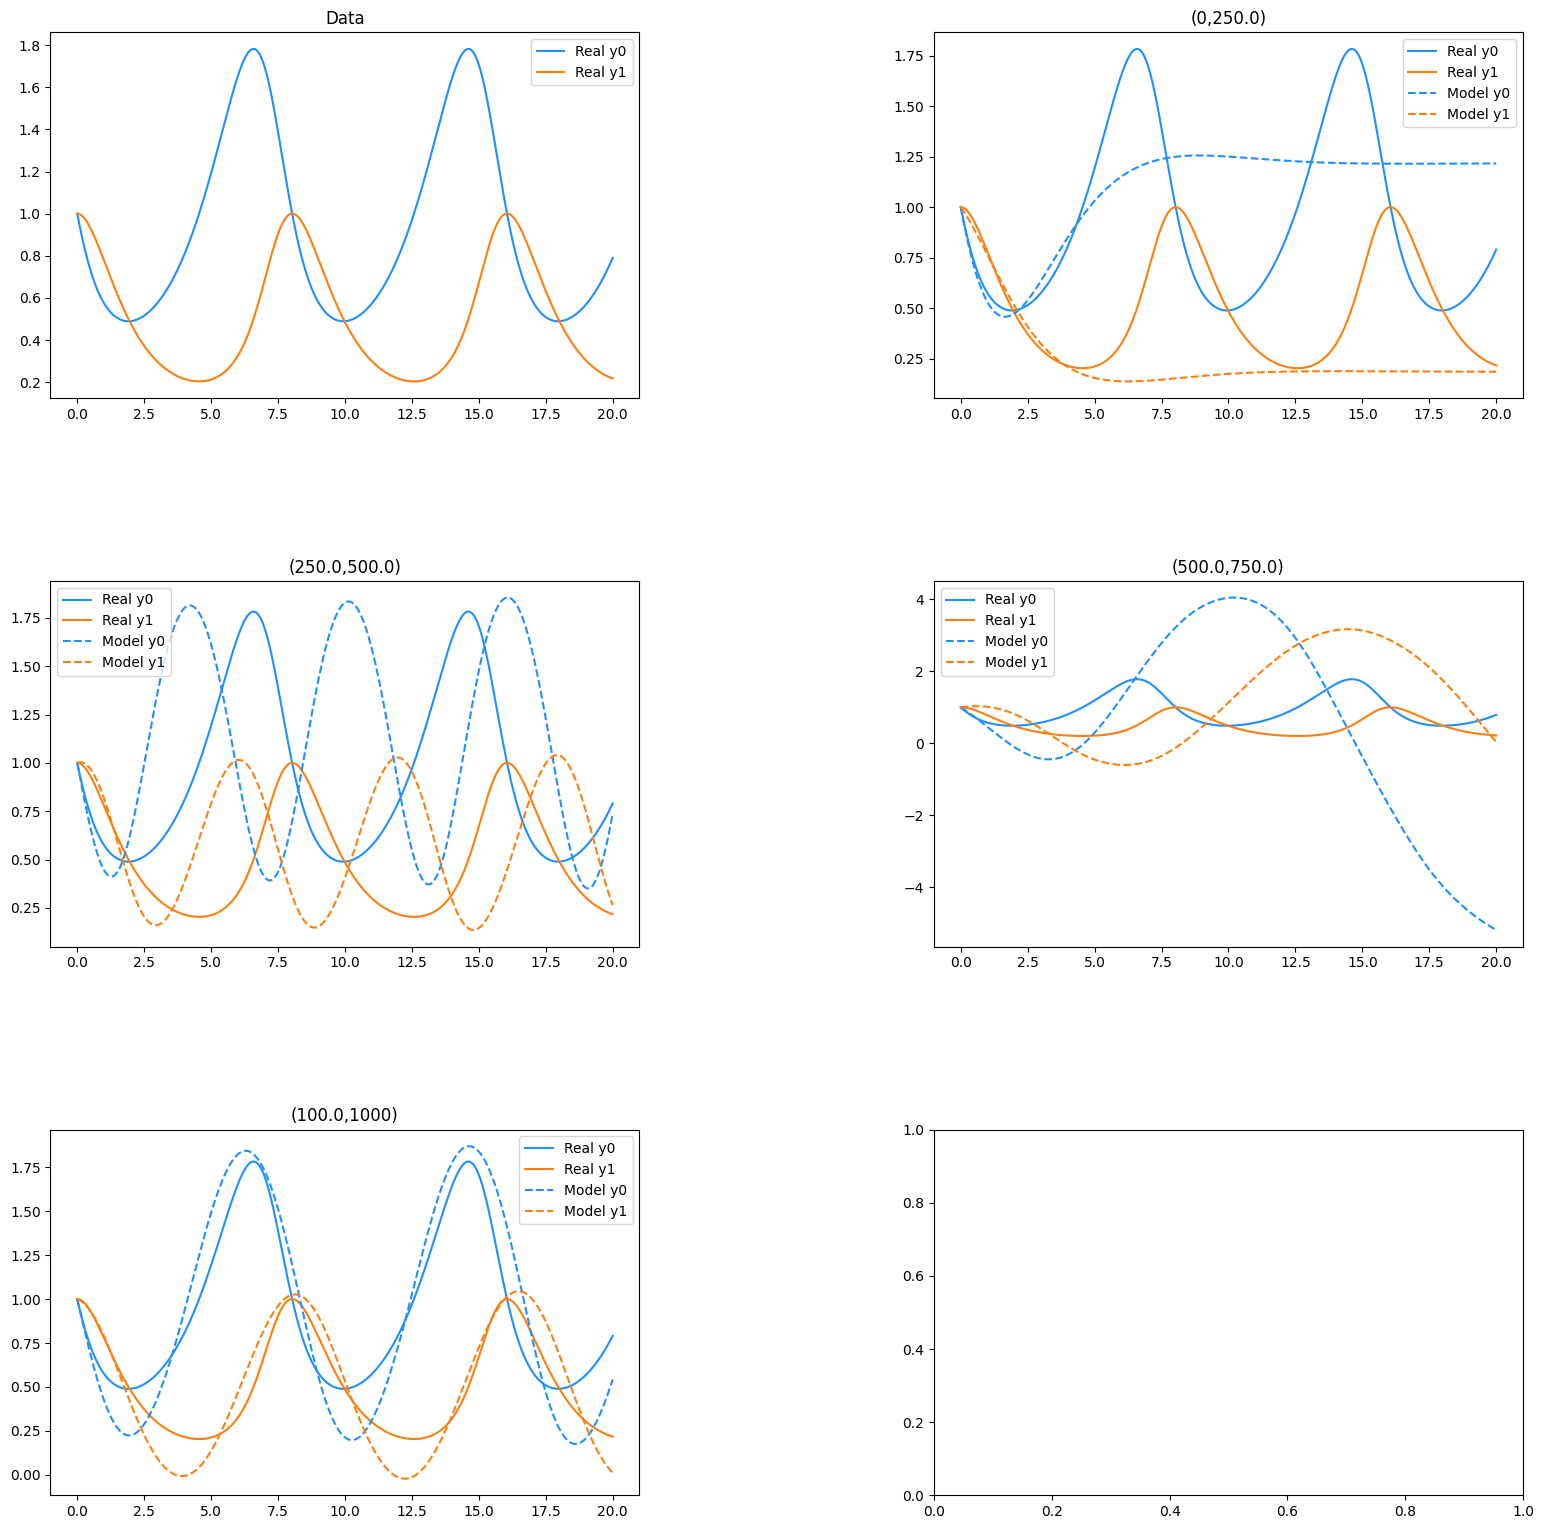

In [273]:
ts, ys, model = main()

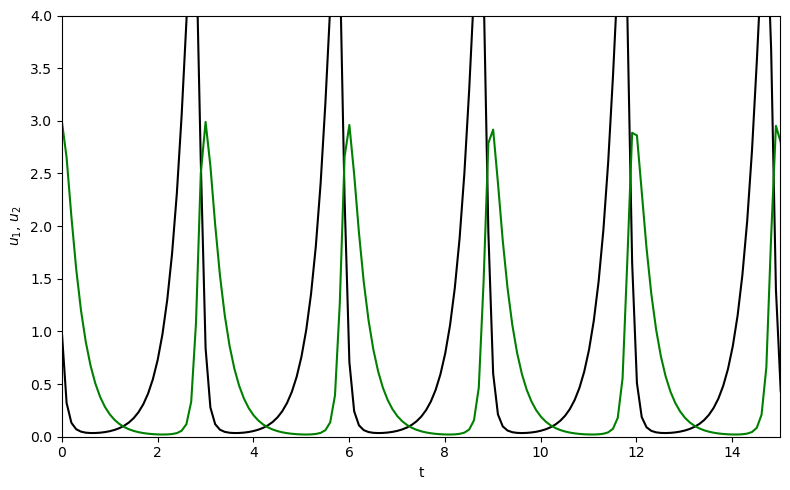

In [129]:
from diffrax import diffeqsolve, ODETerm, Dopri5
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

# Ground-truth dynamic of the system
class Lambda(eqx.Module):
   def forward(self, t, y):
       a, b, c, d = 3, 5, 3, 3
       x1 = y[0][0]
       x2 = y[0][1]
       f0 = a*x1 - b*x1*x2
       f1 = -c*x2 + d*x1*x2
       return jnp.stack([f0, f1])
   
   
data_size = 1000
true_y0 = torch.tensor([[1., 3.]])
t = torch.linspace(0., 100., data_size)

# Batch info
batch_time = 10
# batch_size = 20

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')    



visualize(t, true_y, y_pred=None, iteration=None)



# ode_true = NeuralODE(OneDExample())
# # Create data
# z0 = Variable(torch.Tensor([ [1., 3.] ]))

# t_max = 50
# n_points = 2000

# index_np = np.arange(0, n_points, 1, dtype=np.int32)
# # index_np = np.hstack([index_np[:, None]])
# times_np = np.linspace(0, t_max, num=n_points)
# # times_np = np.hstack([times_np[:, None]])

# # times = torch.from_numpy(times_np[:, :, None]).to(z0)
# times = torch.from_numpy(times_np)

# obs = ode_true(z0, times, return_whole_sequence=True).detach()
# func = NNODEF(2, 512, time_invariant=False)
# ode_trained = NeuralODE(func)


# # ode_trained = NeuralODE(RandomLinearODEF())

In [124]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

torch.Size([64]) torch.Size([32])


ValueError: not enough values to unpack (expected at least 1, got 0)

In [94]:
# def conduct_experiment(ode_true=None, ode_trained=None, n_steps=None, name=None, plot_freq=10):
#     # Create data
#     z0 = Variable(torch.Tensor([-0.5]))
#     t_min = -1
#     t_max = 50
#     n_points = 5000
#     index_np = np.arange(0, n_points, 1, dtype=np.int32)
#     index_np = np.hstack([index_np[:, None]])
#     times_np = np.linspace(t_min, t_max, num=n_points)
#     times_np = np.hstack([times_np[:, None]])

#     # times = torch.from_numpy(times_np[:, :, None]).to(z0).float()
    
#     # print(obs.shape)
#     # torch.tensor([1.0]), torch.tensor([5.0]), torch.tensor([3.0]), times)

#     times = torch.from_numpy(times_np[:, :, None]).to(z0)
#     obs = func_Data_generate(times).float()
#     # obs = ode_true(z0, times, return_whole_sequence=True).detach()
#     # obs = obs 
#     # + torch.randn_like(obs) * 0.01

#     # plt.figure()
#     # plt.plot(to_np(times).flatten(), to_np(obs).flatten())
#     # plt.show()
#     # x = input("Helooo")

#     # Get trajectory of random timespan 
#     min_delta_time = 1.0
#     max_delta_time = 5.0
#     max_points_num = 32
#     def create_batch():
#         t0 = np.random.uniform(0, t_max - max_delta_time)
#         t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

#         idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

#         obs_ = obs[idx]
#         ts_ = times[idx]
#         return obs_, ts_
    
#     # Train Neural ODE
#     optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
#     for i in range(n_steps):

#         obs_, ts_ = create_batch()
#         # print(obs_.dtype, ts_.dtype, obs_[0])
#         z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)

#         # print(z_)
#         loss = F.mse_loss(z_, obs_.detach())
#         # print(loss.item())
#         optimizer.zero_grad()
#         loss.backward(retain_graph=True)
#         optimizer.step()


#         if i % plot_freq == 0:
#             z_p = ode_trained(z0, times, return_whole_sequence=True)
#             # print(obs.shape, times.shape, z_p.shape)
#             plot_trajectories_1D(obs=[obs.flatten()], times=[times.flatten()], trajs=[z_p.flatten()], save=f"{i}.png")
#             clear_output(wait=True)

In [95]:
ode_true = NeuralODE(SriniPolyExample())
func = NNODEF(1, 16, time_invariant=True)
ode_trained = NeuralODE(func)

In [96]:
conduct_experiment(ode_true, ode_trained, 5000, "linear")

KeyboardInterrupt: 